# Implementación de filtro espacial o morfológico

## 1. Integrantes del grupo

Este trabajo pertenece al Grupo 18 - Equipo 3. Los integrantes somos:
- Irene Fanjul i Penella
- Miguel Jiménez Gomis
- Carles Serra Vendrell
- Adrián Bañuls Arias
- Miriam Pardo Cuesta

## 2. Organización de las reuniones

| Reuniones | Descripción |
|------------|:-----------------------------------------------------------------------------------------------------------------------:|
| 21/01/2021 |   Planificación de las tareas a realizar. Elección del software a desarrollar. | 
| 24/01/2021 |   Puesta en común de las posibles soluciones investigadas de forma independiente por cada integrante. |
| 30/01/2021 |   Desarrollo completo de la propuesta software y redacción de las explicaciones pertinentes.|

Todos los integrantes del grupo han participado en todas las reuniones.

## 3. Descripción del objetivo del software propuesto

El presente trabajo se centra en el procesamiento de imágenes de radiografías de huesos fracturados. El objetivo principal del software que se ha desarrollado es el realce de estas fracturas, para que se puedan apreciar con mayor claridad y sin el ruido que supone la aparición parcial de músculos y otros tejidos en las radiografías.

## 4. Software desarrollado y su aplicación paso a paso

En este apartado se recogen las dos soluciones propuestas para el procesamiento de dichas radiografías.

La primera solución propuesta se basa en hacer una umbralización, probando tanto una global como una local, para obtener la binarización de la imagen.
En cambio, la segunda solución propuesta utiliza el algoritmo Canny para la detección de bordes y seguidamente aplica el operador morfológico de la dilatación.

In [ ]:
!wget https://github.com/MiguelJG/PercepcionComputacional/raw/main/Laboratorio%202/radio2.jpg
!wget https://github.com/MiguelJG/PercepcionComputacional/raw/main/Laboratorio%202/radio3.jpg

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from skimage import io, morphology
from skimage.morphology import opening, closing, disk

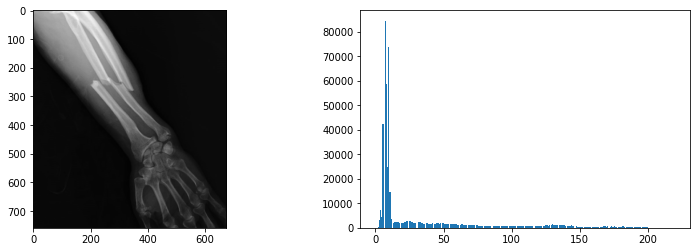

In [ ]:
# Lectura de la imagen
img_1 = cv2.imread('radio3.jpg', cv2.IMREAD_GRAYSCALE)
# Obtención del histograma
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(13,4))
ax1.imshow(img_1, cmap='gray')
ax2.hist(img_1.flatten(), bins=256)
plt.show()

En el histrograma se observa con claridad como la gran mayoría de los pixeles de la imagen tienen intensidades bajas, es decir cercanos al negro. Las demás intensidades se distribuyen de forma uniforme en los demás niveles, lo que complica su segmentación y muestra la dificultad del problema propuesto.

## 4.1. Umbralización global

En primer lugar, se prueba a realizar una umbralización global de la imagen, con el objetio de binarizarla y facilitar la observación de la rotura de los huesos.

(-0.5, 673.5, 758.5, -0.5)

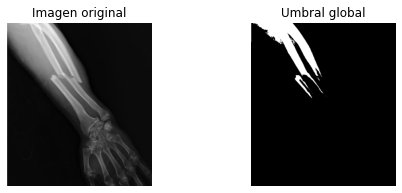

In [ ]:
# Selección del tamaño de las figuras 
matplotlib.rcParams['figure.figsize'] = (8.0, 3.0)

# Prueba con umbralización global
th, bn_global = cv2.threshold(img_1, 140, 255, cv2.THRESH_BINARY)

plt.subplot(1,2,1)
plt.title('Imagen original')
plt.imshow(img_1, cmap='gray')
plt.axis('off')
plt.subplot(1,2,2)
plt.title('Umbral global')
plt.imshow(bn_global, cmap='gray')
plt.axis('off')

Se puede observar que la umbralización global no funciona con la imagen seleccionada, ya que la iluminación de ésta varía en las diferentes regiones de la imagen, por lo que es prácticamente imposible obtener un mismo umbral de binarización adecuado para aplicarlo a toda la imagen y obtener resultados satisfactorios. Por este motivo, se decidió utilizar en su lugar la umbralización adaptativa, la cual trabaja con pequeñas regiones de la imagen obteniendo así un umbral para cada una de ellas.

## 4.2. Umbralización local

Se crea una función para realizar la umbralización local, con la posibilidad de variar sus parámetros. Además, se crea otra función que llama a la anterior para mostrar gráficamente los resultados obtenidos para cada valor seleccionado del parámetro *block_size*.

Después de obtener el mejor resultado posible con la umbralización local para las dos imágenes de prueba, se aplican una serie de transformaciones morfológicas. En concreto, se aplica una dilatación para eliminar el ruido de color negro presente en los huesos así como los contornos del brazo, seguida de una erosión que resalta los huesos. Es decir, se aplica una clausura. Los resultados que se obtienen son relativamente satisfactorios, ya que aunque se consigue eliminar prácticamente todo lo que no es hueso, también se elimina parte de este.

In [ ]:
def umbralizacion_local (img, blk_size, const):
    """Esta función toma como argumentos la imagen a la que aplicar la umbralización local y
    los parámetros blk_size y const.
    img -- Imagen a procesar
    blk_size -- Tamaño del área sobre el que va a tener efecto la umbralización.
    const -- Constante que se resta a la media calculada.
    """
    # Suavizado previo para eliminar el ruido de la imagen
    gray = cv2.medianBlur(np.array(img, dtype = 'uint8'), 5)

    # Aplicación de la función 'adaptiveThreshold' para llevar acabo la umbralización local mediante el método gaussiano
    bn_local = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, blk_size, const)
    return bn_local

In [ ]:
def plot_umb_local (img, lista_blk_size):
    for i in range(len(lista_blk_size)):
        bn_local = umbralizacion_local (img, lista_blk_size[i], 3)
        plt.subplot(len(lista_blk_size)//3,3+len(lista_blk_size)%3, (i+1))
        plt.title('Umbral local BS=' + str(lista_blk_size[i]))
        plt.imshow(bn_local, cmap='gray')
        plt.axis('off')

### 4.2.1. Primera imagen

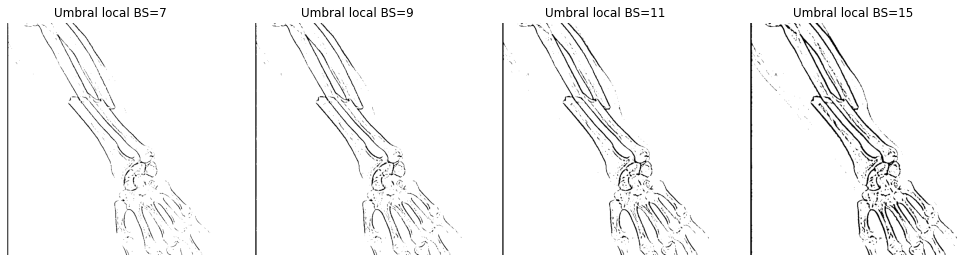

In [ ]:
# Selección del tamaño de las figuras 
matplotlib.rcParams['figure.figsize'] = (17.0, 8.0)

# Creamos una lista con los posibles tamaño de área que se van a probar como parámetro
# para la umbralización local.
lista_blk_size = [7, 9, 11, 15]
plot_umb_local (img_1, lista_blk_size)

Se observa que el mejor resultado para el método de umbralización local se obtiene para una tamaño de area de 9.

(-0.5, 673.5, 758.5, -0.5)

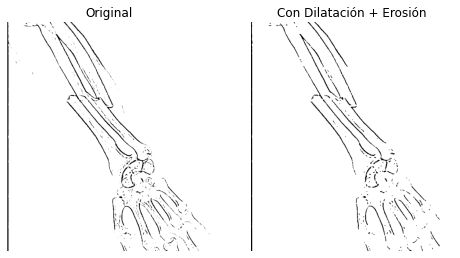

In [ ]:
# Selección del tamaño de las figuras 
matplotlib.rcParams['figure.figsize'] = (8.0, 5.0)
# Se trabaja con el mejor resultado de la umbralización adaptativa
best_bn_local = umbralizacion_local (img_1, 9, 3)
# Se aplica una dilatación seguida de una erosión
dilation = morphology.dilation(image=best_bn_local, selem=disk(1.3))
erosion = morphology.erosion(image=dilation, selem=disk(1.5))

plt.subplot(1,2,1)
plt.title('Original')
plt.imshow(best_bn_local, cmap='gray')
plt.axis('off')
plt.subplot(1,2,2)
plt.title('Con Dilatación + Erosión') # Clausura
plt.imshow(erosion, cmap='gray')
plt.axis('off')

### 4.2.2. Segunda imagen

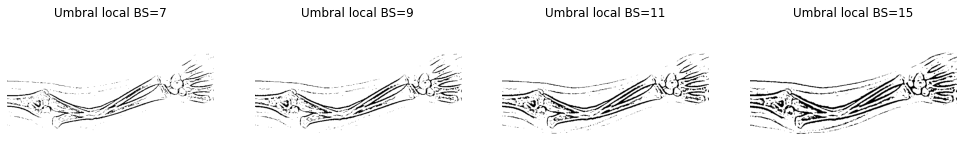

In [ ]:
img_1 = cv2.imread('radio2.jpg', cv2.IMREAD_GRAYSCALE)

# Selección del tamaño de las figuras 
matplotlib.rcParams['figure.figsize'] = (17.0, 8.0)

plot_umb_local (img_1, lista_blk_size)


Se observa que el mejor resultado para el método de umbralización local se obtiene para una tamaño de area de 11.

(-0.5, 599.5, 399.5, -0.5)

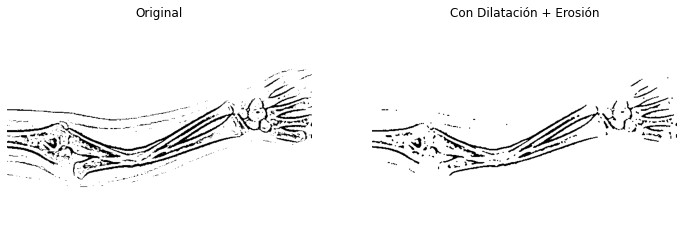

In [ ]:
# Selección del tamaño de las figuras 
matplotlib.rcParams['figure.figsize'] = (12.0, 5.0)
# Se trabaja con el mejor resultado de la umbralización adaptativa
best_bn_local = umbralizacion_local (img_1, 11, 3)
# Se aplica una dilatación seguida de una erosión
dilation = morphology.dilation(image=best_bn_local, selem=disk(1))
erosion = morphology.erosion(image=dilation, selem=disk(1.3))

plt.subplot(1,2,1)
plt.title('Original')
plt.imshow(best_bn_local, cmap='gray')
plt.axis('off')
plt.subplot(1,2,2)
plt.title('Con Dilatación + Erosión') # Clausura
plt.imshow(erosion, cmap='gray')
plt.axis('off')

## 4.3. Filtro de Canny

Además de este método, se ha implementado otra solución para comparar con los resultados anteriores y comprobar si se puede llegar a una mejor solución. En concreto, se ha implementado un filtrado de canny seguido de una dilatación. Los parámetros que pasamos a la función que hemos creado son : la imagen, una histéresis mínima y una histéresis máxima para seleccionar los bordes. 

In [ ]:
# Definición del segundo método para procesar las radiografías
kernel = np.ones((2, 2), np.uint8)

def realce_fracturas(image, hyst_min, hyst_max):
    plt.subplot(2,5,1)
    plt.title('Original')
    plt.imshow(image, cmap='gray')
    plt.axis('off')

    canny = cv2.Canny(image,hyst_min,hyst_max)  
    plt.subplot(2,5,2)
    plt.title('Canny')
    plt.imshow(canny, cmap='gray')
    plt.axis('off')
    
    dilate = cv2.dilate(canny, kernel, iterations=1)
    plt.subplot(2,5,3)
    plt.title('Dilatación')
    plt.imshow(dilate, cmap='gray')
    plt.axis('off')
    
    inverse = cv2.bitwise_not(dilate)
    plt.subplot(2,5,4)
    plt.title('Inversión')
    plt.imshow(inverse, cmap='gray')
    plt.axis('off')

### 4.3.1. Primera imagen

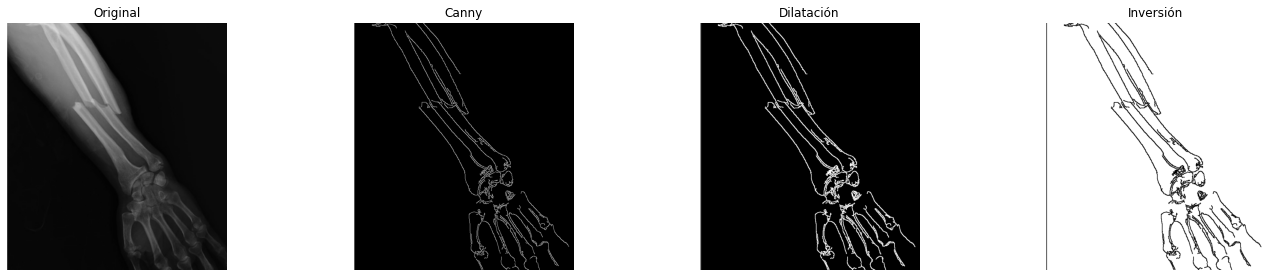

In [ ]:
matplotlib.rcParams['figure.figsize'] = (30.0, 10.0)
radio_3 = cv2.imread('radio3.jpg')
realce_fracturas(radio_3,25,120)

### 4.3.2. Segunda imagen

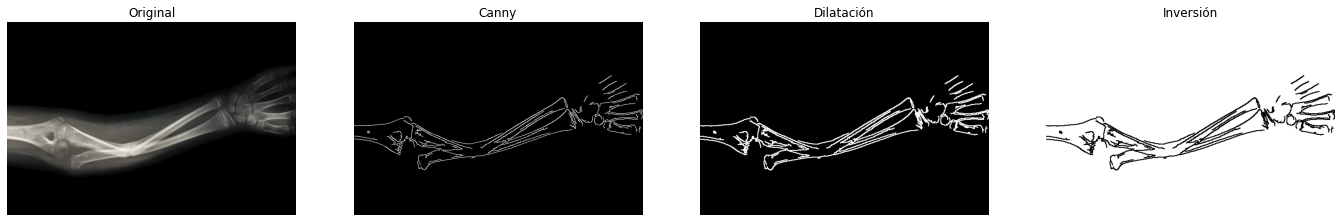

In [ ]:
matplotlib.rcParams['figure.figsize'] = (30.0, 10.0)
radio_2 = cv2.imread('radio2.jpg')
realce_fracturas(radio_2,80,170)

## 5. Conclusiones

Entre las diferentes propuestas, la implementación del filtro de canny junto con la operación morfológica de dilatación es la que mejor resultado nos proporciona, puesto que es capaz de separar satisfactoriamente la estructura ósea del resto de tejidos.